# Alzheimer

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tensorflow.keras.models import load_model

In [3]:
model_path = '/content/drive/MyDrive/Maitri/model_vgg_nineteen.keras'

In [4]:
# Load the model
model = load_model(model_path)

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_3 (Dropout)         (None, 25088)             0         
                                                                 
 batch_normalization_3 (Bat  (None, 25088)             100352    
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 2048)              51382272  
                                                             

In [6]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [7]:
! kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

Dataset URL: https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images
License(s): ODbL-1.0
 94% 32.0M/34.1M [00:02<00:00, 17.6MB/s]
100% 34.1M/34.1M [00:02<00:00, 12.3MB/s]


In [8]:
! unzip /content/alzheimers-dataset-4-class-of-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/m

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os
import tqdm
import glob
import tensorflow

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array

test_datagen  = ImageDataGenerator(rescale = 1./255)
test_dataset  = test_datagen.flow_from_directory(directory = '/content/Alzheimer_s Dataset/test',
                                                 target_size = (224,224),                                          class_mode = 'categorical',
                                                 batch_size = 2500)

Found 1279 images belonging to 4 classes.


In [10]:
X_test,y_test = next(test_dataset)

In [11]:
X_test.shape

(1279, 224, 224, 3)

In [12]:
y_test.shape

(1279, 4)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_3 (Dropout)         (None, 25088)             0         
                                                                 
 batch_normalization_3 (Bat  (None, 25088)             100352    
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 2048)              51382272  
                                                             

1/1 [==============================] - 0s 20ms/step
Calculating image masks...
Passing masked images through the network...
Constructing image with the CAM...


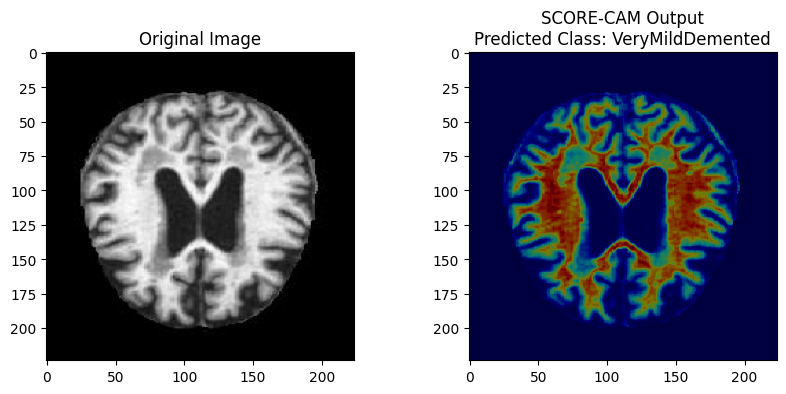

In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def run_cam(model, image, target, verbose=False):
    # Extract convolutional layers
    cnn_layers = []
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.MaxPooling2D) or isinstance(layer, tf.keras.layers.AveragePooling2D):
            cnn_layers.append(layer)

    x = image[tf.newaxis, ...]  # Add batch dimension
    sx, sy = image.shape[:2]

    # 1. Pass input image only through the convolutional layers
    for layer in cnn_layers:
        x = layer(x)

    # 2. Interpolate back to the original size
    x = tf.image.resize(x, (sx, sy), method='bilinear')

    if verbose:
        print("Calculating image masks...")

    # 3. Normalize each mask
    # 4. Project normalized masks to original image
    _, _, _, k = x.shape
    masked_images = []
    for i in range(k):
        feature_map = x[0, :, :, i]
        max_val = tf.reduce_max(feature_map)
        min_val = tf.reduce_min(feature_map)
        normalized_map = (feature_map - min_val) / (max_val - min_val + 1e-4)
        masked_image = image * normalized_map[..., tf.newaxis]
        masked_images.append(masked_image)

    if verbose:
        print("Passing masked images through the network...")

    # 5. Pass each mask through the original network and calculate score
    weight_scores = []
    for m_img in masked_images:
        m_img = m_img[tf.newaxis, ...]
        logits = model(m_img)
        if any(isinstance(layer, tf.keras.layers.Softmax) for layer in model.layers):
            out = tf.nn.softmax(logits, axis=1).numpy()
        else:
            out = np.exp(logits.numpy())

        weight_scores.append(out[0][target])

    if verbose:
        print("Constructing image with the CAM...")

    # 6. Construct cam-points of interest
    output_img = tf.zeros_like(image, dtype=tf.float32)
    for ws, mask in zip(weight_scores, masked_images):
        if not np.isnan(ws):
            output_img += tf.nn.relu(tf.cast(mask * ws, tf.float32))

    # Return only output_img regardless of verbose
    return output_img  # Ensure output_img is returned as tensor

# Define the class names based on test_dataset.class_indices
class_names = {v: k for k, v in {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}.items()}

# Test the run_cam function with a sample image from your dataset
test_image = X_test[0]
predicted_logits = model.predict(test_image[tf.newaxis, ...])
class_index = np.argmax(predicted_logits)
predicted_class_name = class_names[class_index]

output_img = run_cam(model, test_image, class_index, verbose=True)

# Plot the original image and the output CAM image
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(test_image)  # Display the original image
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(test_image / 255.0)  # Normalize image for visualization
# Convert to NumPy array and take the mean across color channels
output_img_grayscale = np.mean(output_img.numpy(), axis=-1)
plt.imshow(output_img_grayscale, cmap='jet', alpha=0.5)
plt.title(f'SCORE-CAM Output\nPredicted Class: {predicted_class_name}')

plt.show()


1/1 [==============================] - 0s 18ms/step
Calculating image masks...
Passing masked images through the network...
Constructing image with the CAM...


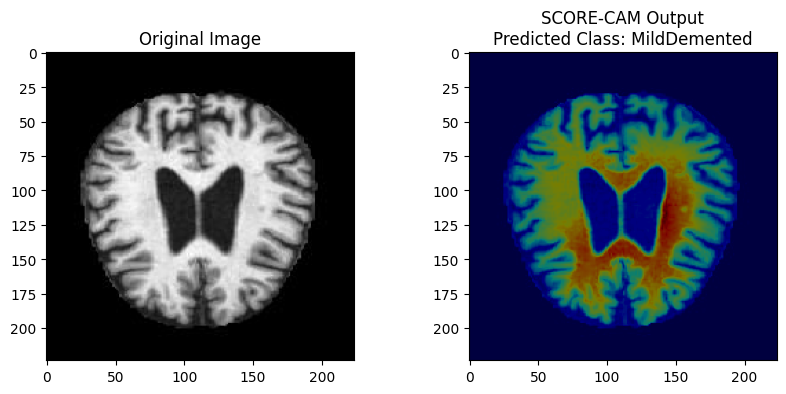

In [48]:
# Test the run_cam function with a sample image from your dataset
test_image = X_test[36]
predicted_logits = model.predict(test_image[tf.newaxis, ...])
class_index = np.argmax(predicted_logits)
predicted_class_name = class_names[class_index]

output_img = run_cam(model, test_image, class_index, cnn_layers, verbose=True) # Added cnn_layers to the function call

# Plot the original image and the output CAM image
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(test_image)  # Display the original image
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(test_image / 255.0)  # Normalize image for visualization
# Convert to NumPy array and take the mean across color channels
output_img_grayscale = np.mean(output_img.numpy(), axis=-1)
plt.imshow(output_img_grayscale, cmap='jet', alpha=0.5)
plt.title(f'SCORE-CAM Output\nPredicted Class: {predicted_class_name}')

plt.show()


1/1 [==============================] - 0s 18ms/step
Calculating image masks...
Passing masked images through the network...
Constructing image with the CAM...


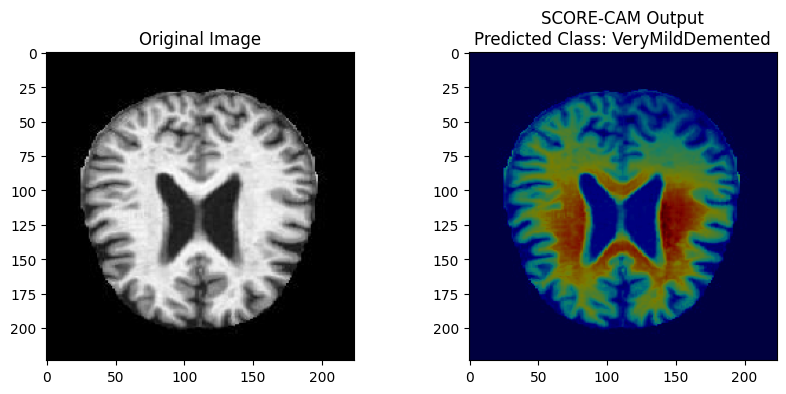

In [47]:
# Test the run_cam function with a sample image from your dataset
test_image = X_test[23]
predicted_logits = model.predict(test_image[tf.newaxis, ...])
class_index = np.argmax(predicted_logits)
predicted_class_name = class_names[class_index]

output_img = run_cam(model, test_image, class_index, cnn_layers, verbose=True) # Added cnn_layers to the function call
# Plot the original image and the output CAM image
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(test_image)  # Display the original image
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(test_image / 255.0)  # Normalize image for visualization
# Convert to NumPy array and take the mean across color channels
output_img_grayscale = np.mean(output_img.numpy(), axis=-1)
plt.imshow(output_img_grayscale, cmap='jet', alpha=0.5)
plt.title(f'SCORE-CAM Output\nPredicted Class: {predicted_class_name}')

plt.show()


1/1 [==============================] - 0s 19ms/step
Calculating image masks...
Passing masked images through the network...
Constructing image with the CAM...


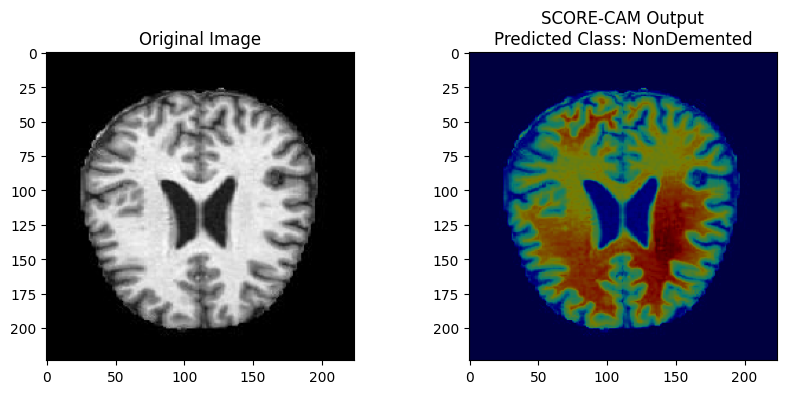

In [46]:
# Test the run_cam function with a sample image from your dataset
test_image = X_test[100]
predicted_logits = model.predict(test_image[tf.newaxis, ...])
class_index = np.argmax(predicted_logits)
predicted_class_name = class_names[class_index]

output_img = run_cam(model, test_image, class_index, cnn_layers, verbose=True) # Added cnn_layers to the function call

# Plot the original image and the output CAM image
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(test_image)  # Display the original image
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(test_image / 255.0)  # Normalize image for visualization
# Convert to NumPy array and take the mean across color channels
output_img_grayscale = np.mean(output_img.numpy(), axis=-1)
plt.imshow(output_img_grayscale, cmap='jet', alpha=0.5)
plt.title(f'SCORE-CAM Output\nPredicted Class: {predicted_class_name}')

plt.show()


In [38]:
def extract_vgg19_conv_layers(model):
    conv_layers = []
    for layer in model.get_layer('vgg19').layers:
        if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.MaxPooling2D, tf.keras.layers.AveragePooling2D)):
            conv_layers.append(layer)
    return conv_layers

# Extract convolutional layers from the VGG19 model
cnn_layers = extract_vgg19_conv_layers(model)

print("CNN layers extracted:")
for layer in cnn_layers:
    print(layer.name, layer.output_shape)

CNN layers extracted:
block1_conv1 (None, 224, 224, 64)
block1_conv2 (None, 224, 224, 64)
block1_pool (None, 112, 112, 64)
block2_conv1 (None, 112, 112, 128)
block2_conv2 (None, 112, 112, 128)
block2_pool (None, 56, 56, 128)
block3_conv1 (None, 56, 56, 256)
block3_conv2 (None, 56, 56, 256)
block3_conv3 (None, 56, 56, 256)
block3_conv4 (None, 56, 56, 256)
block3_pool (None, 28, 28, 256)
block4_conv1 (None, 28, 28, 512)
block4_conv2 (None, 28, 28, 512)
block4_conv3 (None, 28, 28, 512)
block4_conv4 (None, 28, 28, 512)
block4_pool (None, 14, 14, 512)
block5_conv1 (None, 14, 14, 512)
block5_conv2 (None, 14, 14, 512)
block5_conv3 (None, 14, 14, 512)
block5_conv4 (None, 14, 14, 512)
block5_pool (None, 7, 7, 512)


Intermediate outputs shapes:
Feature Map 1: (1, 224, 224, 64)
Feature Map 2: (1, 224, 224, 64)
Feature Map 3: (1, 112, 112, 64)
Feature Map 4: (1, 112, 112, 128)
Feature Map 5: (1, 112, 112, 128)
Feature Map 6: (1, 56, 56, 128)
Feature Map 7: (1, 56, 56, 256)
Feature Map 8: (1, 56, 56, 256)
Feature Map 9: (1, 56, 56, 256)
Feature Map 10: (1, 56, 56, 256)
Feature Map 11: (1, 28, 28, 256)
Feature Map 12: (1, 28, 28, 512)
Feature Map 13: (1, 28, 28, 512)
Feature Map 14: (1, 28, 28, 512)
Feature Map 15: (1, 28, 28, 512)
Feature Map 16: (1, 14, 14, 512)
Feature Map 17: (1, 14, 14, 512)
Feature Map 18: (1, 14, 14, 512)
Feature Map 19: (1, 14, 14, 512)
Feature Map 20: (1, 14, 14, 512)
Feature Map 21: (1, 7, 7, 512)


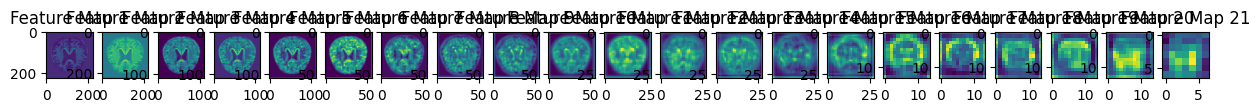

In [40]:
# Visualize intermediate feature maps for the first few convolutional layers in VGG19
intermediate_layer_model = tf.keras.Model(inputs=model.get_layer('vgg19').input, outputs=[layer.output for layer in cnn_layers])
intermediate_output = intermediate_layer_model(test_image[tf.newaxis, ...])

print("Intermediate outputs shapes:")
for i, feature_map in enumerate(intermediate_output):
    print(f'Feature Map {i+1}:', feature_map.shape)

plt.figure(figsize=(15, 5))
for i, feature_map in enumerate(intermediate_output):
    plt.subplot(1, len(intermediate_output), i+1)  # Update to use len(intermediate_output)
    feature_map_mean = np.mean(feature_map[0, :, :, :], axis=-1)  # Calculate mean across channels
    plt.imshow(feature_map_mean, cmap='viridis')
    plt.title(f'Feature Map {i+1}')

plt.show()

Intermediate outputs shapes:
Feature Map 1: (1, 224, 224, 64)
Feature Map 2: (1, 224, 224, 64)
Feature Map 3: (1, 112, 112, 64)
Feature Map 4: (1, 112, 112, 128)
Feature Map 5: (1, 112, 112, 128)
Feature Map 6: (1, 56, 56, 128)
Feature Map 7: (1, 56, 56, 256)
Feature Map 8: (1, 56, 56, 256)
Feature Map 9: (1, 56, 56, 256)
Feature Map 10: (1, 56, 56, 256)
Feature Map 11: (1, 28, 28, 256)
Feature Map 12: (1, 28, 28, 512)
Feature Map 13: (1, 28, 28, 512)
Feature Map 14: (1, 28, 28, 512)
Feature Map 15: (1, 28, 28, 512)
Feature Map 16: (1, 14, 14, 512)
Feature Map 17: (1, 14, 14, 512)
Feature Map 18: (1, 14, 14, 512)
Feature Map 19: (1, 14, 14, 512)
Feature Map 20: (1, 14, 14, 512)
Feature Map 21: (1, 7, 7, 512)


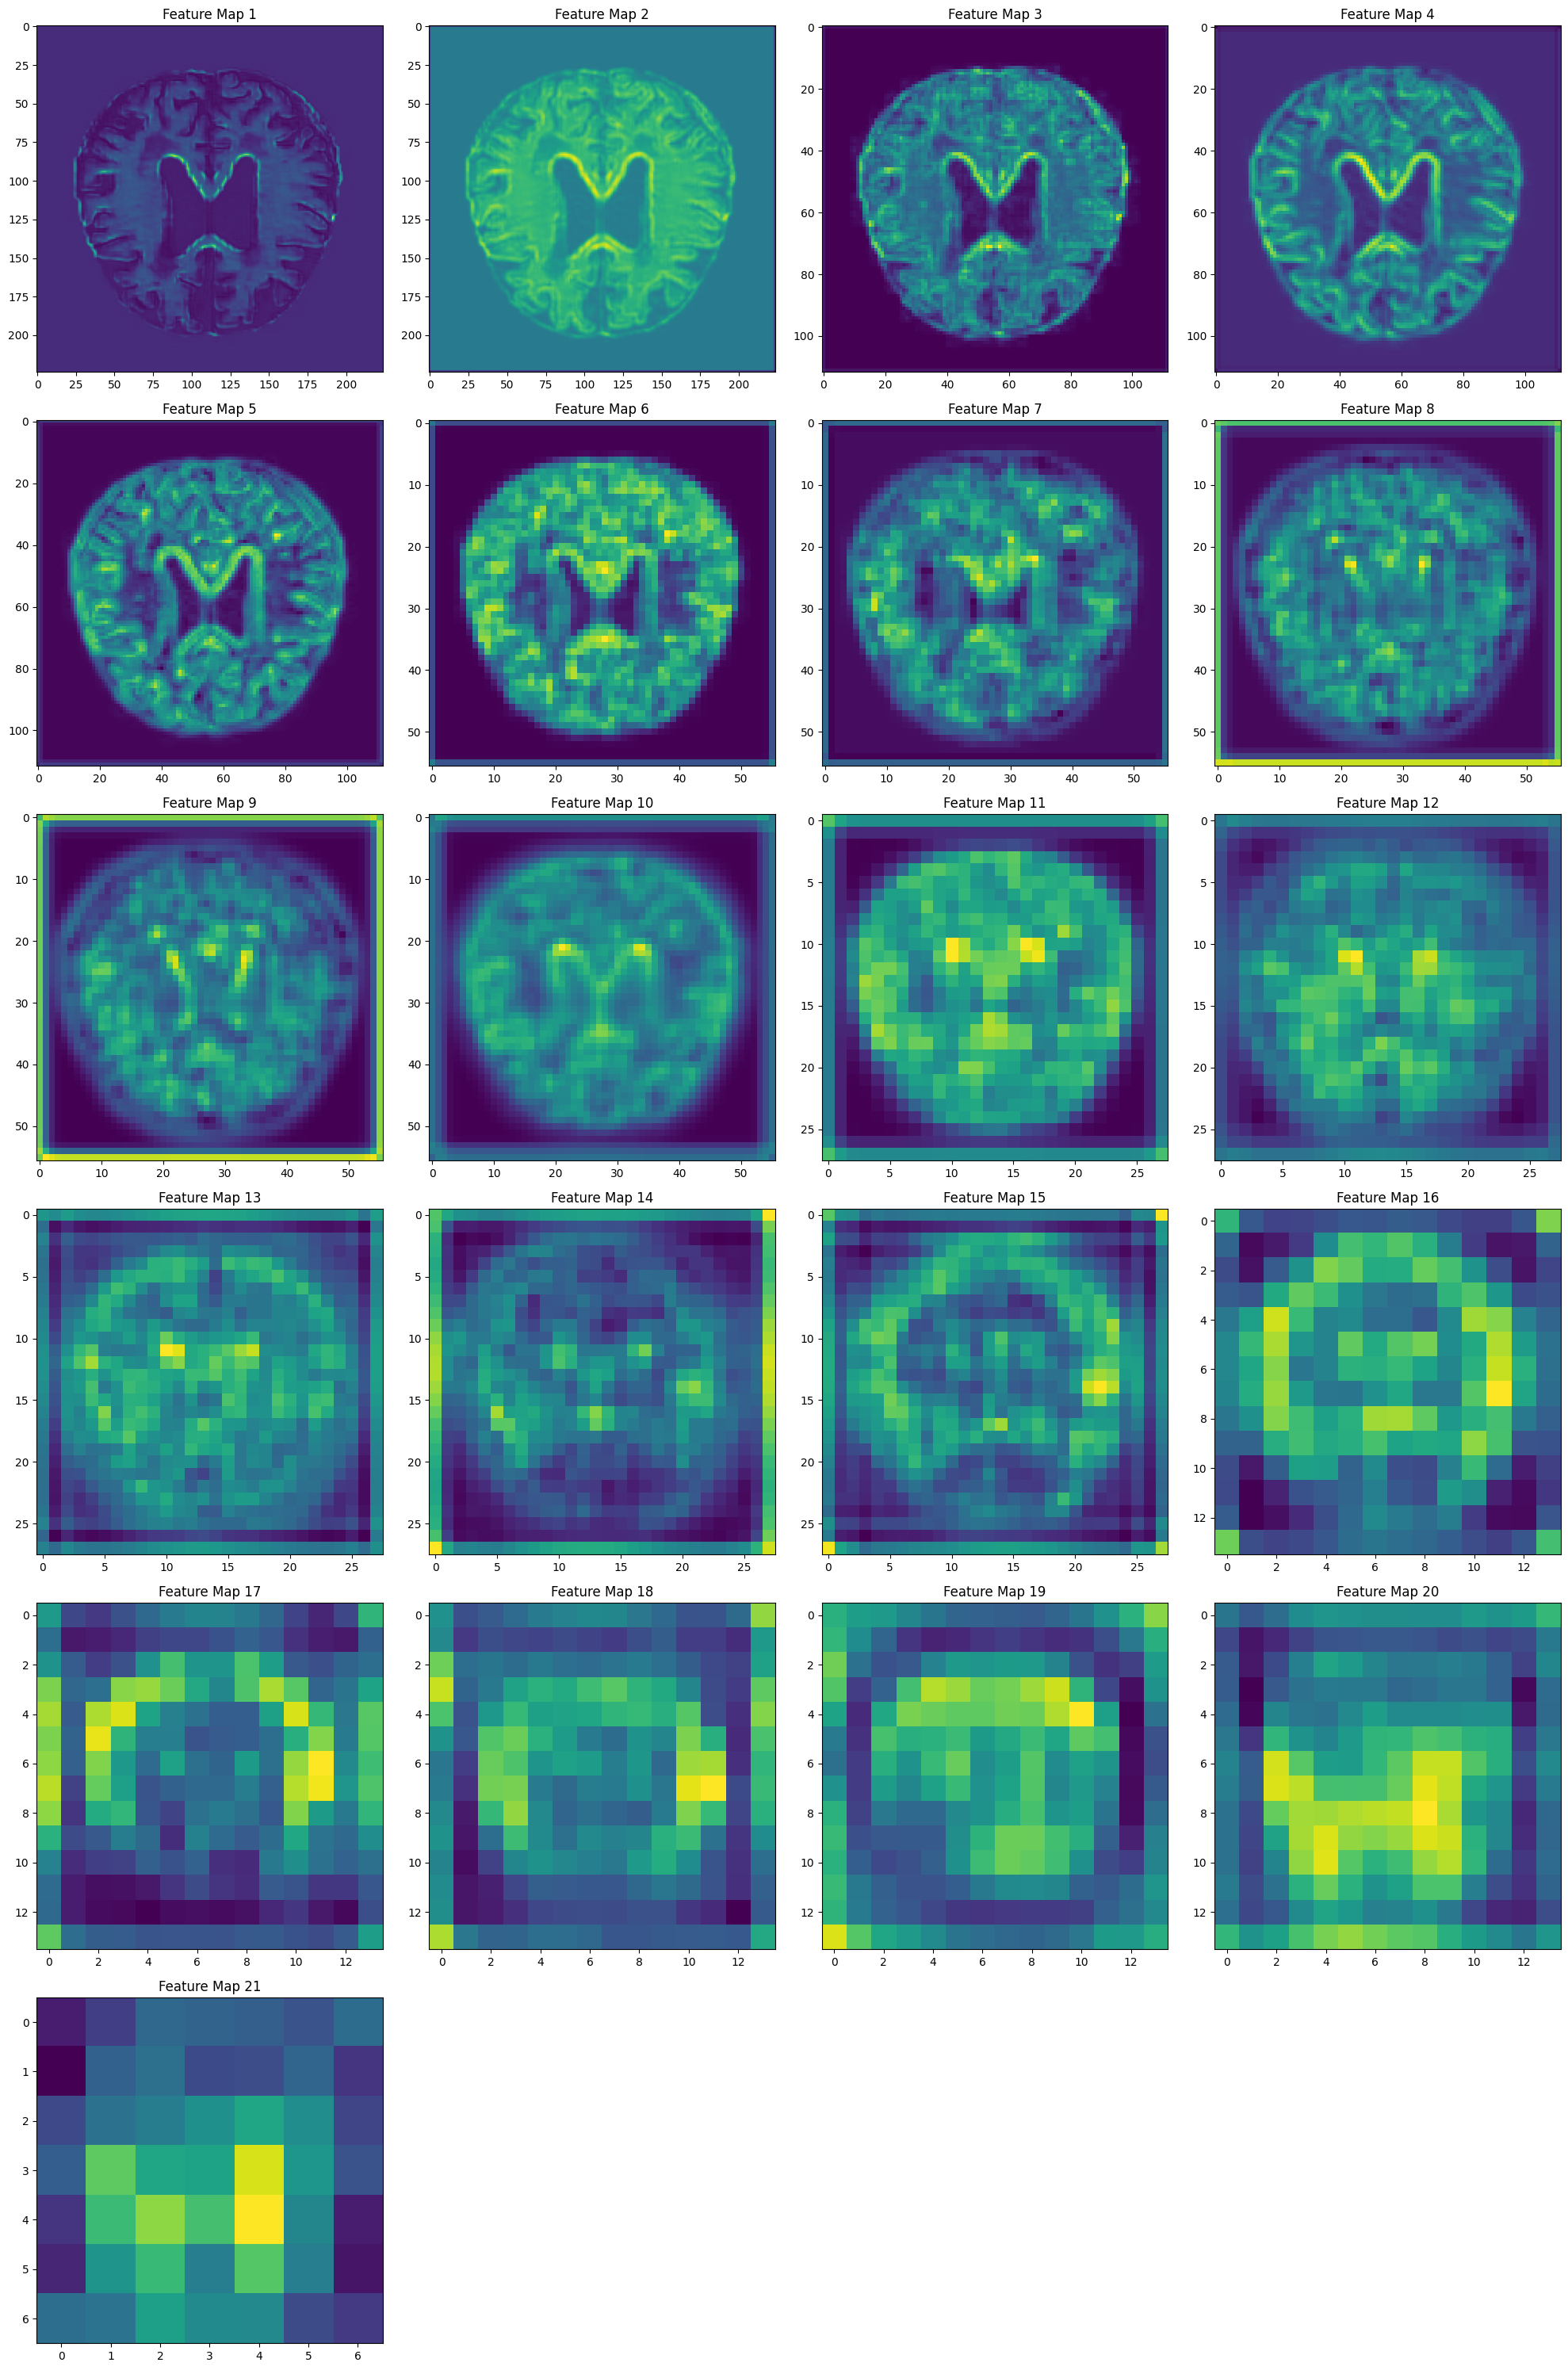

In [41]:
# Visualize intermediate feature maps for the first few convolutional layers in VGG19
intermediate_layer_model = tf.keras.Model(inputs=model.get_layer('vgg19').input, outputs=[layer.output for layer in cnn_layers])
intermediate_output = intermediate_layer_model(test_image[tf.newaxis, ...])

print("Intermediate outputs shapes:")
for i, feature_map in enumerate(intermediate_output):
    print(f'Feature Map {i+1}:', feature_map.shape)

num_feature_maps = len(intermediate_output)
num_cols = 4  # Number of columns for subplots
num_rows = num_feature_maps // num_cols + (1 if num_feature_maps % num_cols != 0 else 0)  # Calculate number of rows

plt.figure(figsize=(20, 5 * num_rows))
for i, feature_map in enumerate(intermediate_output):
    plt.subplot(num_rows, num_cols, i + 1)
    feature_map_mean = np.mean(feature_map[0, :, :, :], axis=-1)  # Calculate mean across channels
    plt.imshow(feature_map_mean, cmap='viridis')
    plt.title(f'Feature Map {i+1}')

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 19ms/step
Calculating image masks...
Passing masked images through the network...
Constructing image with the CAM...


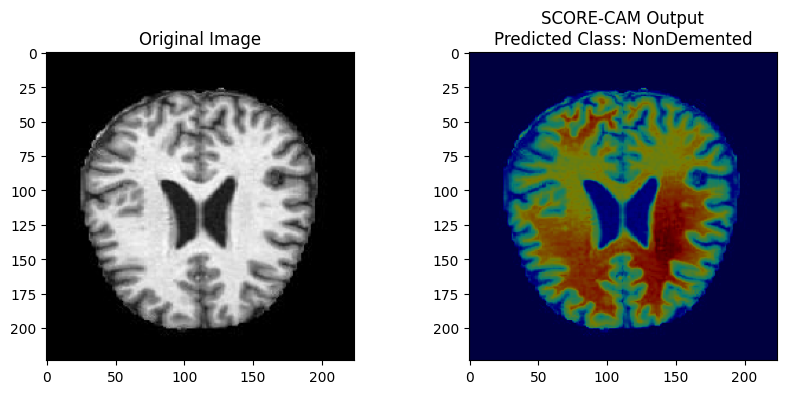

In [44]:
test_image = X_test[100]
predicted_logits = model.predict(test_image[tf.newaxis, ...])
class_index = np.argmax(predicted_logits)
predicted_class_name = class_names[class_index]

output_img = run_cam(model, test_image, class_index, cnn_layers, verbose=True) # Added cnn_layers to the function call

# Plot the original image and the output CAM image
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(test_image)  # Display the original image
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(test_image / 255.0)  # Normalize image for visualization
# Convert to NumPy array and take the mean across color channels
output_img_grayscale = np.mean(output_img.numpy(), axis=-1)
plt.imshow(output_img_grayscale, cmap='jet', alpha=0.5)
plt.title(f'SCORE-CAM Output\nPredicted Class: {predicted_class_name}')

plt.show()
# Visualize intermediate feature maps for the first few convolutional layers in VGG19


Intermediate outputs shapes:
Feature Map 1: (1, 224, 224, 64)
Feature Map 2: (1, 224, 224, 64)
Feature Map 3: (1, 112, 112, 64)
Feature Map 4: (1, 112, 112, 128)
Feature Map 5: (1, 112, 112, 128)
Feature Map 6: (1, 56, 56, 128)
Feature Map 7: (1, 56, 56, 256)
Feature Map 8: (1, 56, 56, 256)
Feature Map 9: (1, 56, 56, 256)
Feature Map 10: (1, 56, 56, 256)
Feature Map 11: (1, 28, 28, 256)
Feature Map 12: (1, 28, 28, 512)
Feature Map 13: (1, 28, 28, 512)
Feature Map 14: (1, 28, 28, 512)
Feature Map 15: (1, 28, 28, 512)
Feature Map 16: (1, 14, 14, 512)
Feature Map 17: (1, 14, 14, 512)
Feature Map 18: (1, 14, 14, 512)
Feature Map 19: (1, 14, 14, 512)
Feature Map 20: (1, 14, 14, 512)
Feature Map 21: (1, 7, 7, 512)


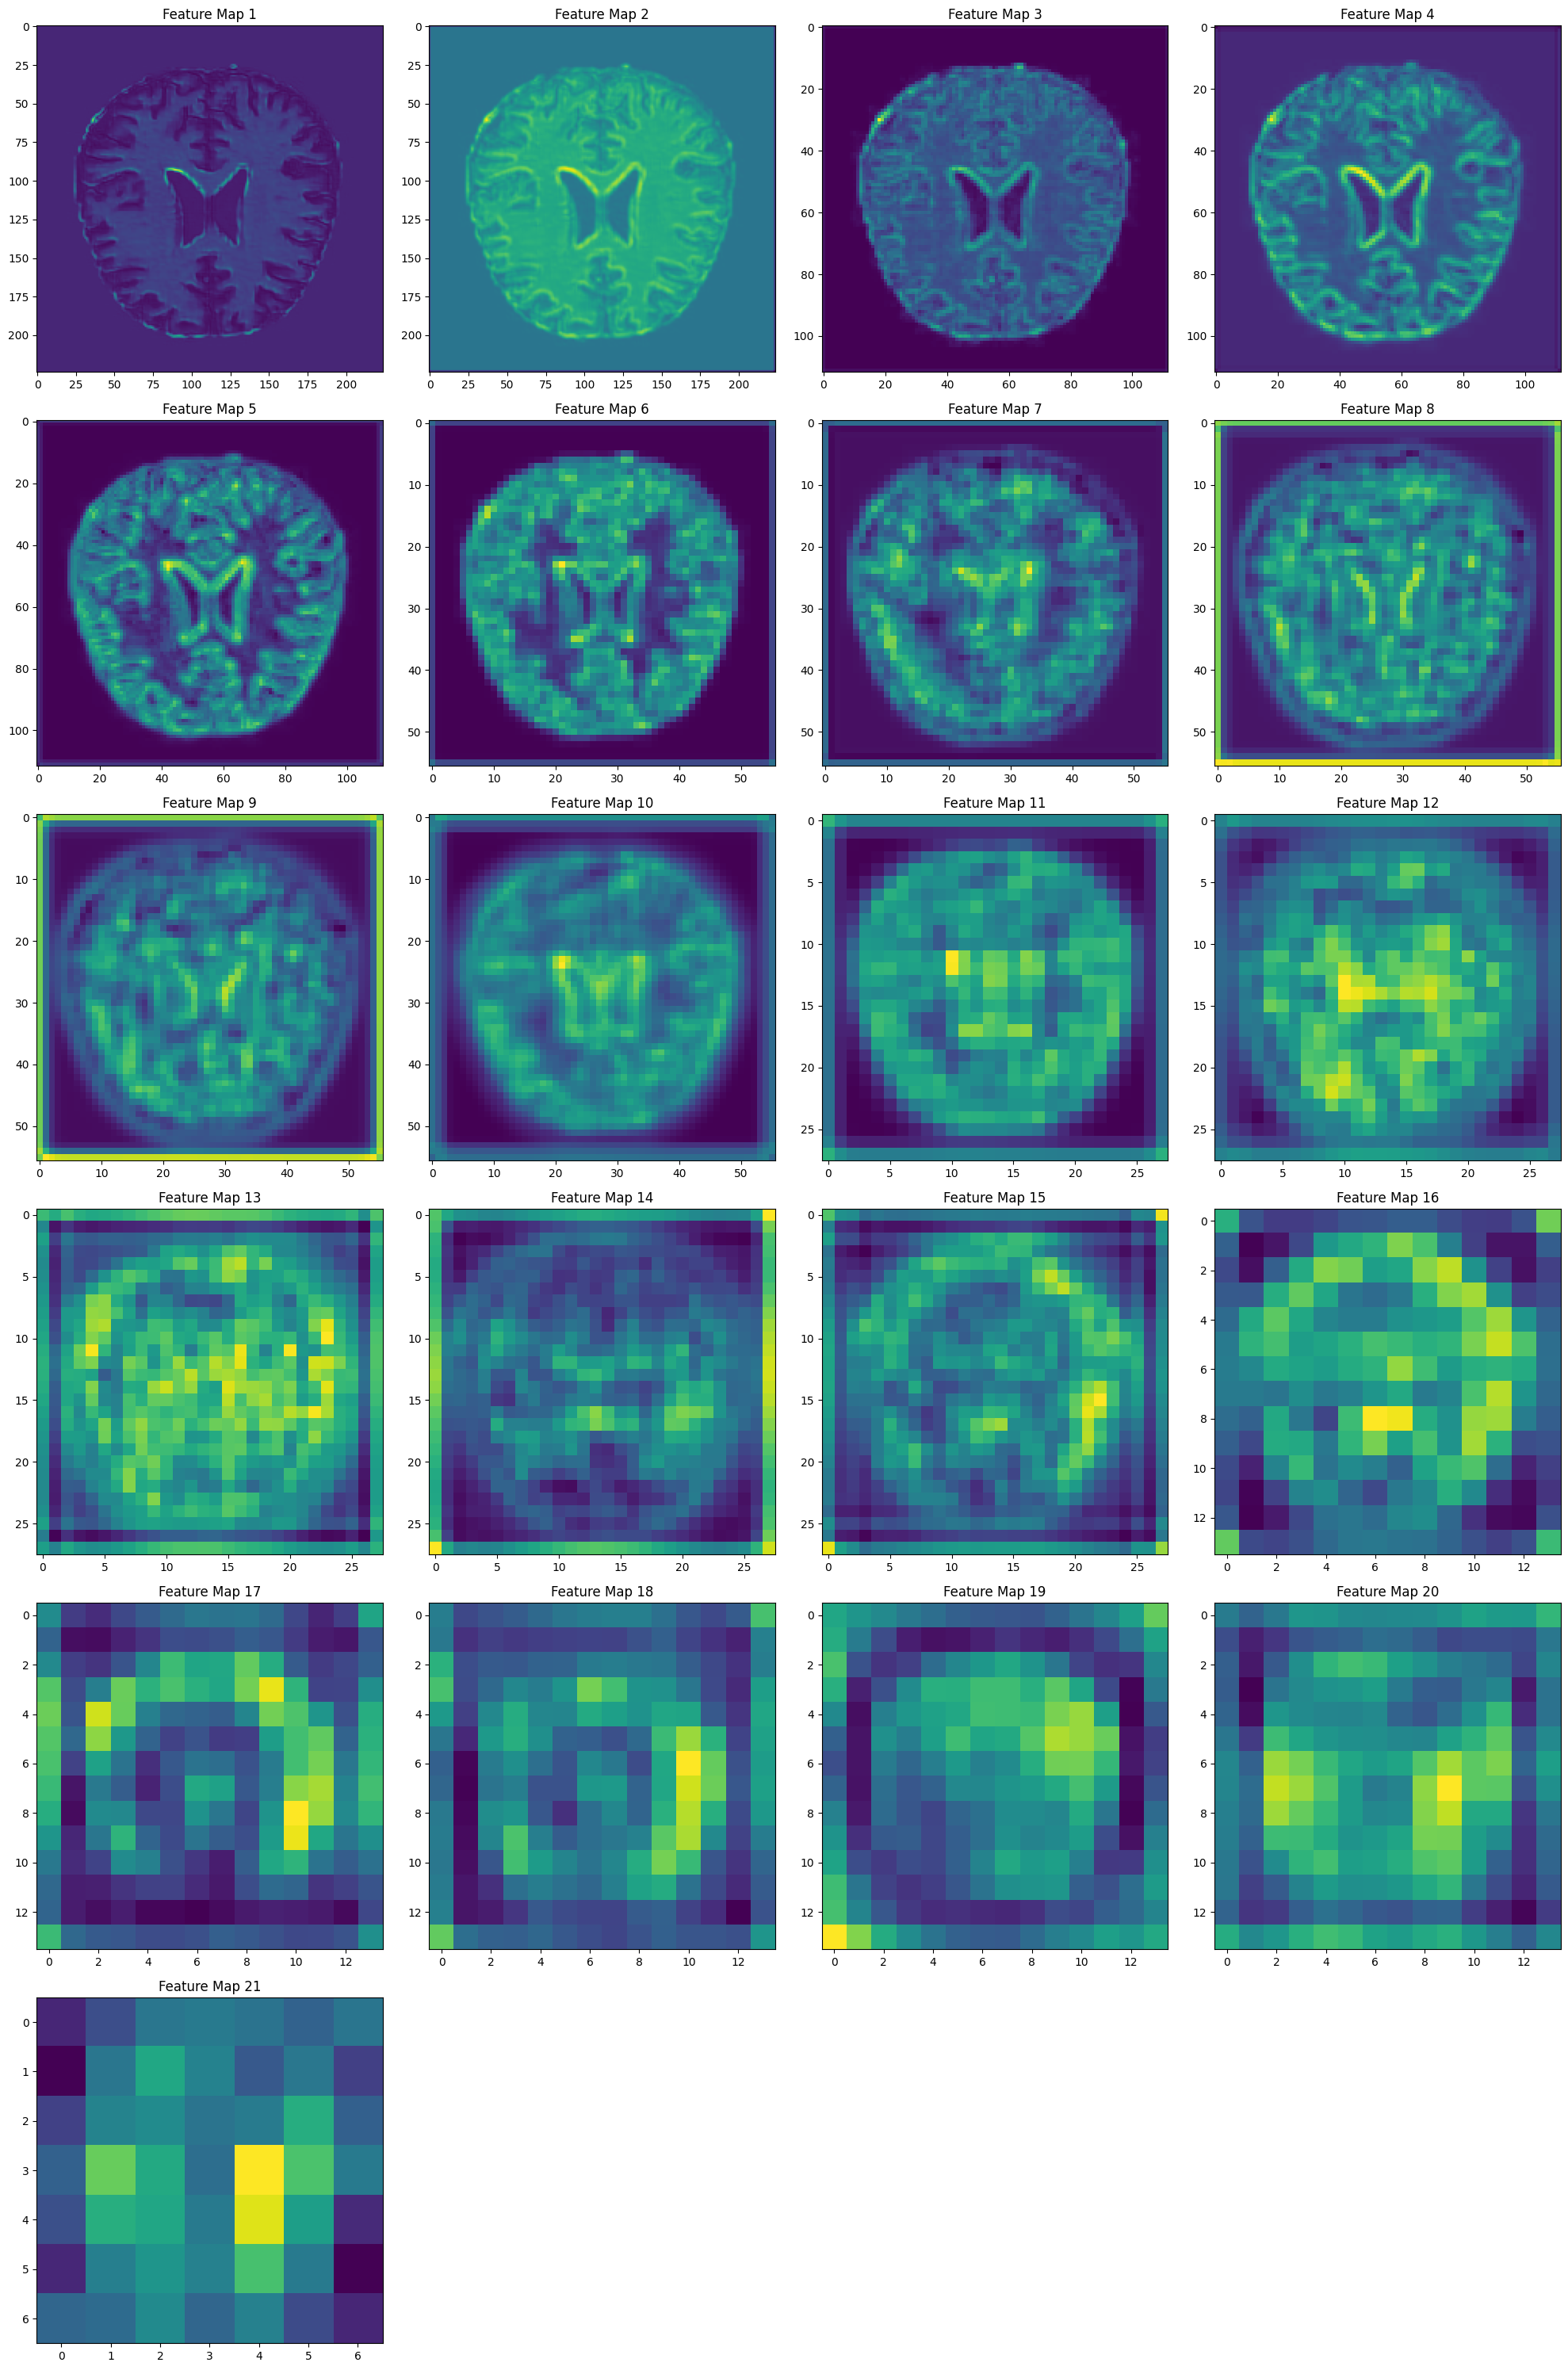

In [45]:
intermediate_layer_model = tf.keras.Model(inputs=model.get_layer('vgg19').input, outputs=[layer.output for layer in cnn_layers])
intermediate_output = intermediate_layer_model(test_image[tf.newaxis, ...])

print("Intermediate outputs shapes:")
for i, feature_map in enumerate(intermediate_output):
    print(f'Feature Map {i+1}:', feature_map.shape)

num_feature_maps = len(intermediate_output)
num_cols = 4  # Number of columns for subplots
num_rows = num_feature_maps // num_cols + (1 if num_feature_maps % num_cols != 0 else 0)  # Calculate number of rows

plt.figure(figsize=(20, 5 * num_rows))
for i, feature_map in enumerate(intermediate_output):
    plt.subplot(num_rows, num_cols, i + 1)
    feature_map_mean = np.mean(feature_map[0, :, :, :], axis=-1)  # Calculate mean across channels
    plt.imshow(feature_map_mean, cmap='viridis')
    plt.title(f'Feature Map {i+1}')

plt.tight_layout()
plt.show()
